# BME590 Unet++

In [1]:
# Import Packages
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import tensorflow as tf
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import optimizers

#Resize the image to 96*96
IMG_WIDTH = 96
IMG_HEIGHT = 96
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
#Get Image ID
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [3]:
# Get train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [03:03<00:00,  3.65it/s]


Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 77.31it/s]


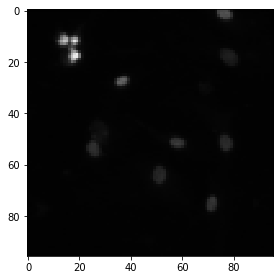

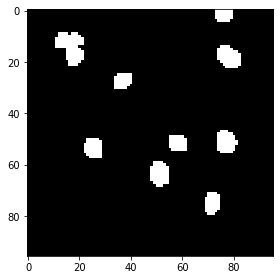

In [4]:
#Check train image and train mask
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [5]:
test_X = X_train[0:67]
test_Y = Y_train[0:67]

In [6]:
X_train = X_train[67:]
Y_train = Y_train[67:]

In [7]:
#Define Intersection over Union (IoU)
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)        
        if true == 0:
            metric += (pred == 0)
            continue
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union        
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10        
        metric += iou        
    metric /= batch_size
    return metric

def my_iou_metric(label, pred):
    return tf.compat.v1.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

In [8]:
#Define BC Dice Loss Function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(K.cast(y_true, 'float32'))
    y_pred_f = K.flatten(K.cast(y_pred, 'float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)

def bc_dice_loss(y_true, y_pred):
    return 0.5 * tf.python.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [9]:
#Set parameters
dropout_rate = 0.1
activation = "elu"
def conv_block(input_tensor, num_of_channels, kernel_size=3):
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation=activation, kernel_initializer = 'he_normal', padding='same' )(input_tensor)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(num_of_channels, (kernel_size, kernel_size), activation=activation, kernel_initializer = 'he_normal', padding='same')(x)
    x = Dropout(dropout_rate)(x)
    return x

In [10]:
#Build and train our neural network
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

up1_2 = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(c2)
conv1_2 = concatenate([up1_2,c1],axis=3)
conv1_2 = conv_block(conv1_2, num_of_channels=32)

c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.1) (c3)
c3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

up2_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
conv2_2 = concatenate([up2_2, c2], axis=3)
conv2_2 = conv_block(conv2_2, num_of_channels=64)

up1_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, conv1_2], axis=3)
conv1_3 = conv_block(conv1_3, num_of_channels=32)

c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.1) (c4)
c4 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

up3_2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
conv3_2 = concatenate([up3_2, c3], axis=3)
conv3_2 = conv_block(conv3_2, num_of_channels=128)

up2_3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], axis=3)
conv2_3 = conv_block(conv2_3, num_of_channels=64)

up1_4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, conv1_2, conv1_3], axis=3)
conv1_4 = conv_block(conv1_4, num_of_channels=32)

c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.1) (c5)
c5 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

up4_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
conv4_2 = concatenate([up4_2, c4],  axis=3)
conv4_2 = conv_block(conv4_2,  num_of_channels=256)

up3_3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, c3, conv3_2],  axis=3)
conv3_3 = conv_block(conv3_3, num_of_channels=128)

up2_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], axis=3)
conv2_4 = conv_block(conv2_4, num_of_channels=64)

up1_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, conv1_2, conv1_3, conv1_4],  axis=3)
conv1_5 = conv_block(conv1_5, num_of_channels=32)

nestnet_output = Conv2D(1, (1, 1), activation ='sigmoid',
                        kernel_initializer= 'he_normal', padding='same')(conv1_5)
    
model = Model(inputs=[inputs], outputs=[nestnet_output])
model.compile(optimizer='adam', loss=bc_dice_loss,metrics=[my_iou_metric],lr = 3e-4)
model.summary()

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
_______________

concatenate (Concatenate)       (None, 96, 96, 64)   0           conv2d_transpose[0][0]           
                                                                 conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 12, 12, 256)  0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 24, 24, 128)  147584      dropout_10[0][0]                 
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 48, 48, 64)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 96, 96, 32)   18464       concatenate[0][0]                
__________

__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 96, 96, 32)   36896       concatenate_5[0][0]              
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 48, 48, 64)   36928       dropout_21[0][0]                 
__________________________________________________________________________________________________
dropout_14 (Dropout)            (None, 96, 96, 32)   0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 48, 48, 64)   0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 96, 96, 32)   9248        dropout_14[0][0]                 
__________

In [11]:
#Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('Unet++.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples
Epoch 1/50
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
603/603 [==============================] - 10s 16ms/sample - loss: -0.3727 - my_iou_metric: 0.2448
Epoch 2/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.7209 - my_iou_metric: 0.5418
Epoch 3/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.7938 - my_iou_metric: 0.6526
Epoch 4/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8190 - my_iou_metric: 0.6904
Epoch 5/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8313 - my_iou_metric: 0.7126
Epoch 6/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8410 - my_iou_metric: 0.7255
Epoch 7/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8487 - my_iou_metric: 0.7381
Epoch 8/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8507 - my_iou_metric: 0.7365
Epoch 9/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8471 - my_iou_metric: 0.7317
Epoch 10/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8475 - my_iou_metric: 0.7368
Epoch 11/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8535 - my_iou_metric: 0.7464
Epoch 12/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8623 - my_iou_metric: 0.7573
Epoch 13/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8599 - my_iou_metric: 0.7535
Epoch 14/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8641 - my_iou_metric: 0.7642
Epoch 15/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8661 - my_iou_metric: 0.7646
Epoch 16/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8704 - my_iou_metric: 0.7774
Epoch 17/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8708 - my_iou_metric: 0.7700
Epoch 18/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8707 - my_iou_metric: 0.7768
Epoch 19/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8699 - my_iou_metric: 0.7794
Epoch 20/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8741 - my_iou_metric: 0.7818
Epoch 21/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8746 - my_iou_metric: 0.7836
Epoch 22/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8725 - my_iou_metric: 0.7821
Epoch 23/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8780 - my_iou_metric: 0.7893
Epoch 24/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8813 - my_iou_metric: 0.7963
Epoch 25/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8803 - my_iou_metric: 0.7938
Epoch 26/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8806 - my_iou_metric: 0.7950
Epoch 27/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8832 - my_iou_metric: 0.8017
Epoch 28/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8844 - my_iou_metric: 0.8023
Epoch 29/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8871 - my_iou_metric: 0.8107
Epoch 30/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8864 - my_iou_metric: 0.8045
Epoch 31/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8878 - my_iou_metric: 0.8053
Epoch 32/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8892 - my_iou_metric: 0.8086
Epoch 33/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8934 - my_iou_metric: 0.8190
Epoch 34/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.8926 - my_iou_metric: 0.8176
Epoch 35/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8938 - my_iou_metric: 0.8228
Epoch 36/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8946 - my_iou_metric: 0.8206
Epoch 37/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.9004 - my_iou_metric: 0.8309
Epoch 38/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.8947 - my_iou_metric: 0.8218
Epoch 39/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9029 - my_iou_metric: 0.8388
Epoch 40/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.9034 - my_iou_metric: 0.8371
Epoch 41/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9073 - my_iou_metric: 0.8429
Epoch 42/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9080 - my_iou_metric: 0.8436
Epoch 43/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.9058 - my_iou_metric: 0.8411
Epoch 44/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9162 - my_iou_metric: 0.8627
Epoch 45/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9192 - my_iou_metric: 0.8667
Epoch 46/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.9236 - my_iou_metric: 0.8773
Epoch 47/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9257 - my_iou_metric: 0.8824
Epoch 48/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9239 - my_iou_metric: 0.8775
Epoch 49/50


603/603 [==============================] - 4s 6ms/sample - loss: -0.9285 - my_iou_metric: 0.8866
Epoch 50/50
603/603 [==============================] - 4s 6ms/sample - loss: -0.9307 - my_iou_metric: 0.8895


In [12]:
# Predict on train, and test
model = load_model('Unet++.h5', custom_objects={'my_iou_metric': my_iou_metric,'bc_dice_loss':bc_dice_loss})
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

603/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 3s 5ms/sample
65/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [13]:
preds_test_in_train = model.predict(test_X, verbose=1)
preds_test_t_in_train = (preds_test_in_train > 0.5).astype(np.uint8)

67/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [14]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(preds_test_t_in_train, test_Y)
print('Unet++ Final result on test set: ', m.result().numpy()) 

Unet++ Final result on test set:  0.9278728


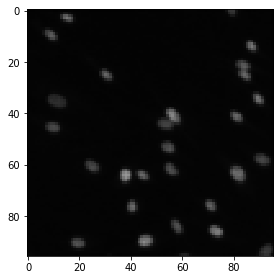

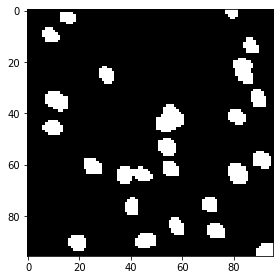

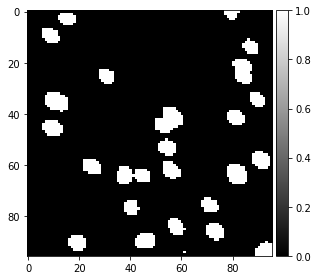

In [15]:
#Check train
ix = 10
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap = 'gray')
plt.show()

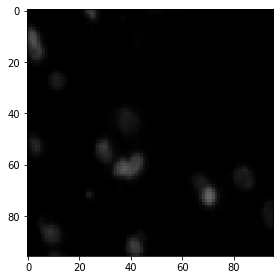

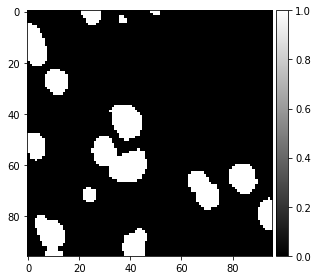

In [16]:
#Check test
ix = 11
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap = 'gray')
plt.show()

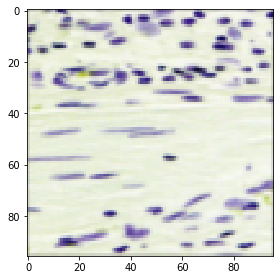

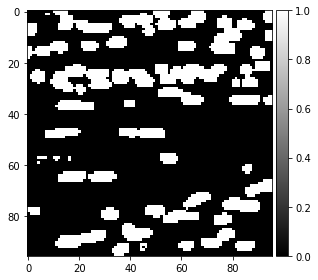

In [17]:
#Check test
ix = 12
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap = 'gray')
plt.show()

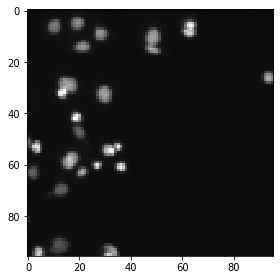

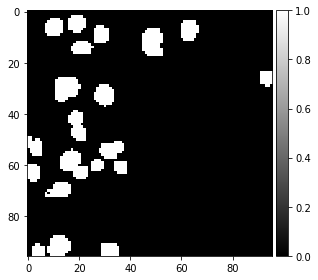

In [18]:
#Check test
ix = 13
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]),cmap = 'gray')
plt.show()

Since the original test set in the dataset has no mask, we cannot calculate the iou. I use 10% data in train set to calculate the iou, and I use real data in test set to plot these figures.